In [1]:
from cil.optimisation.functions import L2NormSquared, TotalVariation, MixedL21Norm
from cil.optimisation.operators import BlockOperator, FiniteDifferenceOperator, CompositionOperator, DiagonalOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.ccpi_regularisation.functions import FGP_dTV

from cil.utilities.display import show2D
from cil.recon import FDK

from cil.framework import BlockGeometry
from cil.optimisation.algorithms import FISTA
from cil.optimisation.functions import (LeastSquares, SmoothMixedL21Norm, MixedL21Norm, 
                                        OperatorCompositionFunction, KullbackLeibler, BlockFunction,
                                        IndicatorBox, L2NormSquared)
from cil.optimisation.operators import  BlurringOperator, GradientOperator, LinearOperator

from sirf.STIR import *
from sirf.contrib.BSREM import BSREM
from sirf.contrib.partitioner import partitioner

import numpy as np
import tqdm
import matplotlib.pyplot as plt

import brainweb

# set up default colour map for visualisation
cmap = "gray"

# set the backend for FBP and the ProjectionOperator
device = 'gpu'

msg = MessageRedirector()# Needed for get_subsets()
AcquisitionData.set_storage_scheme('memory')


# Simulated sphere cone beam reconstruction using directional total variation 

In this notebook we use directional TV to reconstruct a slice from a simulated sphere cone beam dataset where the forward model involves a gaussian blur and then a tomographic cone beam projection

## Load data 

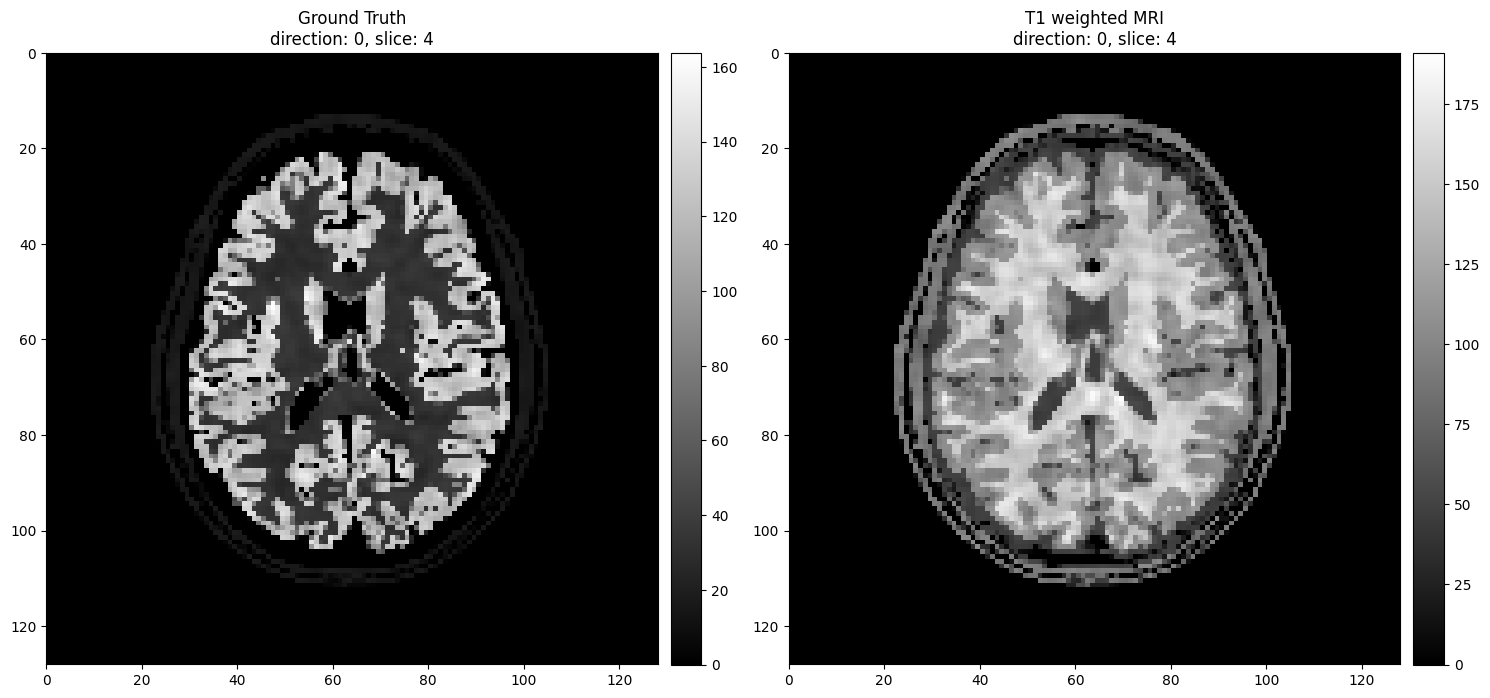

In [2]:
#%% Load data - for now we'll use brainweb
fname, url= sorted(brainweb.utils.LINKS.items())[0]
files = brainweb.get_file(fname, url, ".")
data = brainweb.load_file(fname)

brainweb.seed(1337)

vol = brainweb.get_mmr_fromfile(fname,
        petNoise=1, t1Noise=0.75, t2Noise=0.75,
        petSigma=1, t1Sigma=1, t2Sigma=1)

arr_dict = {'PET': vol['PET'], 'T1': vol['T1'], 'T2': vol['T2'], 'uMap': vol['uMap']}

dim = (8,128,128) # desired shape of the images

for key, image in arr_dict.items():
    shape = image.shape
    z_start, y_start, x_start = (shape[0] - dim[0])//2, (shape[1] - dim[1])//2, (shape[2] - dim[2])//2
    z_end, y_end, x_end = z_start + dim[0], y_start + dim[1], x_start + dim[2]
    
    arr_dict[key] = image[z_start:z_end, y_start:y_end, x_start:x_end]

show2D([arr_dict['PET'], arr_dict['T1']], title = ['Ground Truth', 'T1 weighted MRI'], origin = 'upper', num_cols = 2)

In [3]:
image_dict = {}
vsize = (2.03125, 2.08626, 2.08626)
for key, image in arr_dict.items():
    image_dict[key] = ImageData()
    image_dict[key].initialise(dim = dim, vsize = vsize)
    image_dict[key].fill(image)

In [4]:
template_sinogram = AcquisitionData('./template_sinogram.hs')






	from the Interfile header, and remaining fields set from the
	Siemens mMR model.




	num_rings 1 should be a multiple of num_axial_crystals_per_singles_unit 16

Scanner parameters:= 
Scanner type := Siemens mMR
Number of rings                          := 1
Number of detectors per ring             := 504
Inner ring diameter (cm)                 := 65.6
Average depth of interaction (cm)        := 0.7
Distance between rings (cm)              := 0.40625
Default bin size (cm)                    := 0.208626
View offset (degrees)                    := 0
Maximum number of non-arc-corrected bins := 150
Default number of arc-corrected bins     := 150
Energy resolution := 0.145
Reference energy (in keV) := 511
Number of blocks per bucket in transaxial direction         := 1
Number of blocks per bucket in axial direction              := 2
Number of crystals per block in axial direction             := 8
Number of crystals per block in transaxial direction        := 9
Number of detector layer

## Define point spread function 

In [5]:
def psf(n=5, sig=1.):
    """
    creates psf with side length `n` and a sigma of `sig`
    """
    ax = np.linspace(-(n - 1) / 2., (n - 1) / 2., n)
    gauss_x = np.exp(-0.5 * np.square(ax) / np.square(sig))
    gauss_y = np.exp(-0.5 * np.square(ax) / np.square(sig))
    gauss_z = np.exp(-0.5 * np.square(ax) / np.square(sig))
    kernel_3d = np.outer(gauss_z, gauss_y).reshape(n, n, 1) * gauss_x.reshape(1, 1, n)
    return kernel_3d / np.sum(kernel_3d)

PSF=psf(5,2)
convolve=BlurringOperator(PSF, image_dict['PET'])

## Blur the image and recalculate the measured data, adding noise 

In [6]:
def add_poission_noise(acquistion_data, noise_level=10, seed=10):
    """
    Adds poisson noise to acquisition data
    """
    np.random.seed(seed)
    noisy_data = np.random.poisson(acquistion_data.as_array()/noise_level)*noise_level
    return acquistion_data.clone().fill(noisy_data)




Going ahead anyway.
no additive term added
applying unnormalisation...ok
no background term added

Going ahead anyway.
no additive term added
applying unnormalisation...ok
no background term added


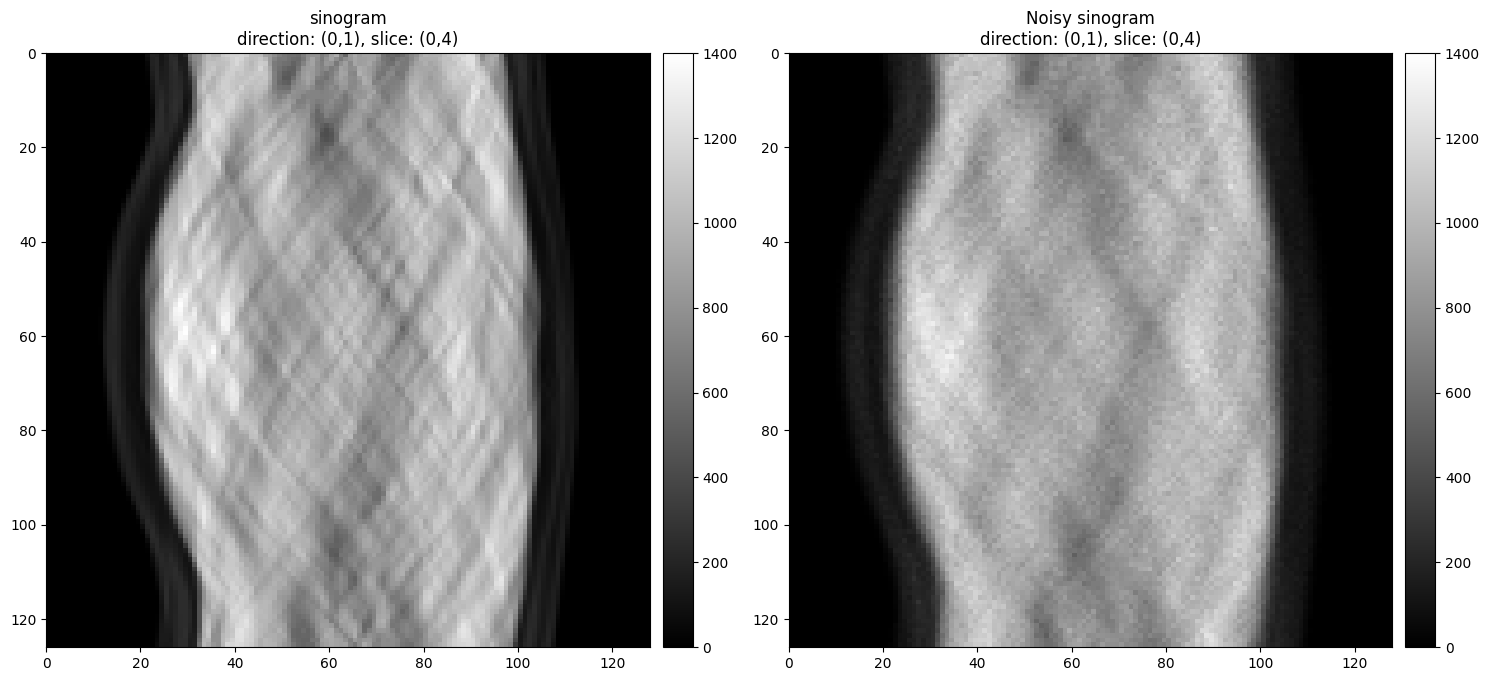

In [7]:
A = AcquisitionModelUsingRayTracingMatrix()
A.set_num_tangential_LORs(10)
A_asm = AcquisitionModelUsingRayTracingMatrix()
A_asm.set_num_tangential_LORs(10)
A.set_acquisition_sensitivity(AcquisitionSensitivityModel(image_dict['uMap'], A_asm))
A.set_up(template_sinogram, image_dict['PET'])

sinogram = A.direct(image_dict['PET'])
noisy_sinogram = add_poission_noise(sinogram, noise_level=1)

forward=CompositionOperator(A, convolve)
blurred_sinogram=forward.direct(image_dict['PET'])
blurred_noisy_sinogram=add_poission_noise(blurred_sinogram, noise_level=1)

show2D([sinogram, blurred_noisy_sinogram], title = ['sinogram', 'Noisy sinogram'], origin = 'upper', num_cols = 2, fix_range=[(0,1400), (0,1400)])

## OSEM reconstruction
We use the PET forward model (ignoring the blurring operator) to produce a reconstruction which is both blurred and noisy compared to the ground truth image. 

In [8]:
objective_function = make_Poisson_loglikelihood(blurred_noisy_sinogram, acq_model=A)
objective_function.set_num_subsets(8)
reconstructor = OSMAPOSLReconstructor()
reconstructor.set_num_subiterations(8)
reconstructor.set_objective_function(objective_function)
reconstructor.set_up(image_dict['PET'])

cyl = TruncateToCylinderProcessor()
cyl.set_strictly_less_than_radius(True)

current_estimate = image_dict['PET'].get_uniform_copy(1)
objective_list = []
full_iterations = 50

for i in range(full_iterations):
    reconstructor.reconstruct(current_estimate)
    objective_list.append(-objective_function(current_estimate))
    print(f"Iteration: {i}, Objective: {objective_list[-1]}", end = '\r')
    # remove any weird stuff from edge effects
    cyl.apply(current_estimate)

show2D([reconstructor.get_current_estimate(), image_dict['PET']], title = ['reconstructed image', 'ground truth'], origin = 'upper', num_cols = 2)

plt.plot(objective_list)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')


Going ahead anyway.


KeyboardInterrupt: 

In [ ]:
def RL(initial, convolution, iterations, eta=1e-6):

    objective_values = []

    current_estimate = initial.clone()

    for i in range(iterations):
        current_estimate*= convolution.adjoint(initial/(convolution.direct(current_estimate)+eta))
        convolved_estimate = convolution.direct(current_estimate)
        objective_values.append(convolved_estimate.sum() - (initial * (convolved_estimate+eta).log()).sum())

        print(f"Iteration: {i}, Objective: {objective_values[-1]}", end = '\r')

    return current_estimate, objective_values

In [ ]:
new_estimate, obj = RL(current_estimate, convolve, 20)

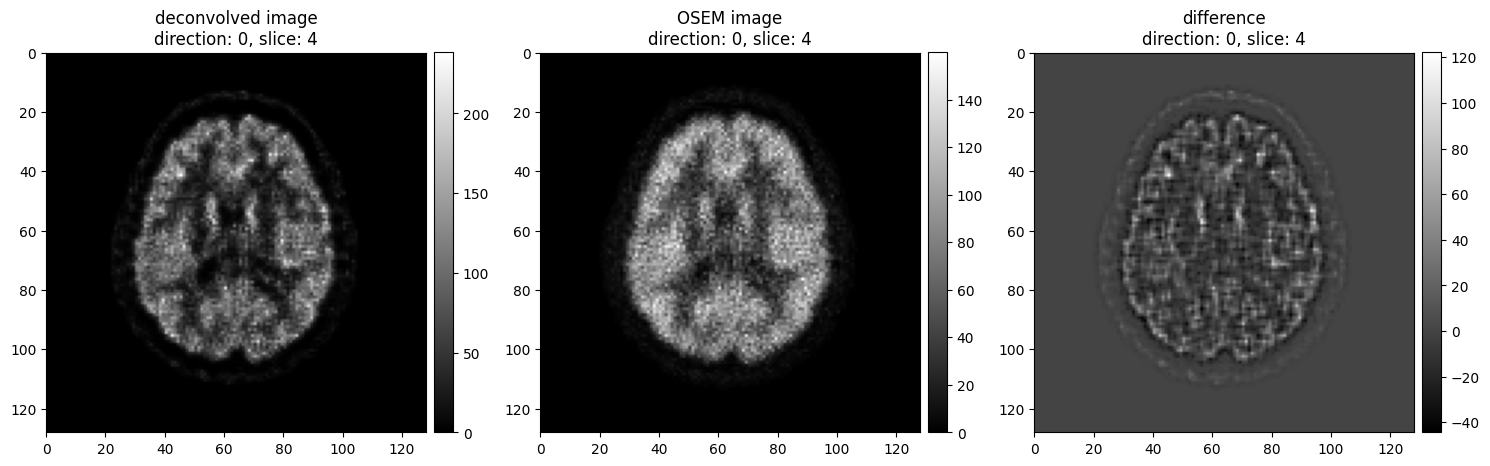

Text(0, 0.5, 'Objective Function Value')

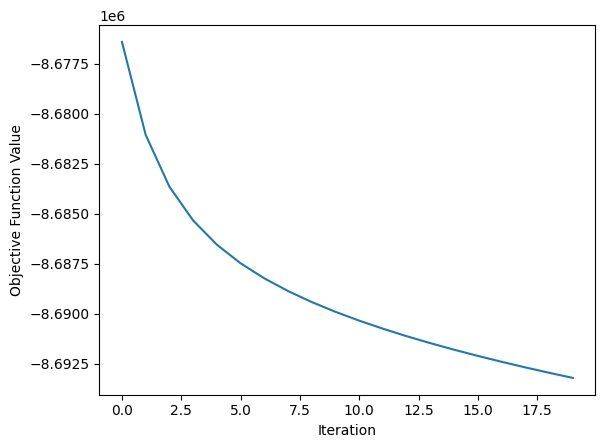

In [ ]:
show2D([new_estimate, current_estimate, new_estimate-current_estimate], 
       title = ['deconvolved image', 'OSEM image', 'difference'], 
       origin = 'upper', num_cols = 3, fix_range=[(0,150,), (0,150), (-40,40)],
       cmap = [cmap, cmap, 'seismic'])

plt.plot(obj)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

In [ ]:
new_estimate_noisy, obj = RL(current_estimate, convolve, 500)

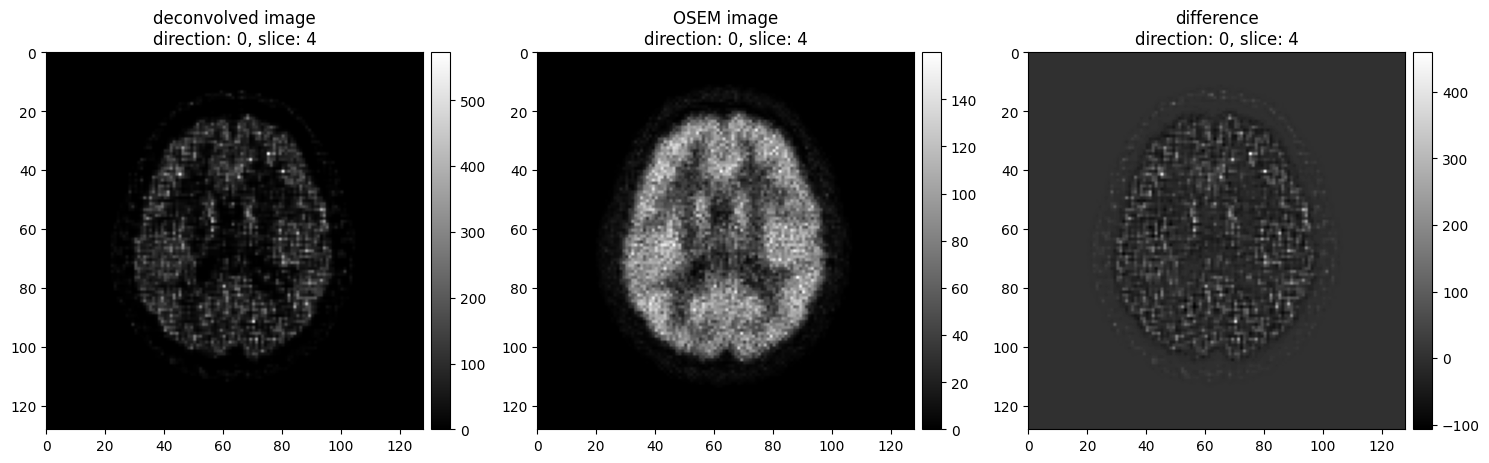

Text(0, 0.5, 'Objective Function Value')

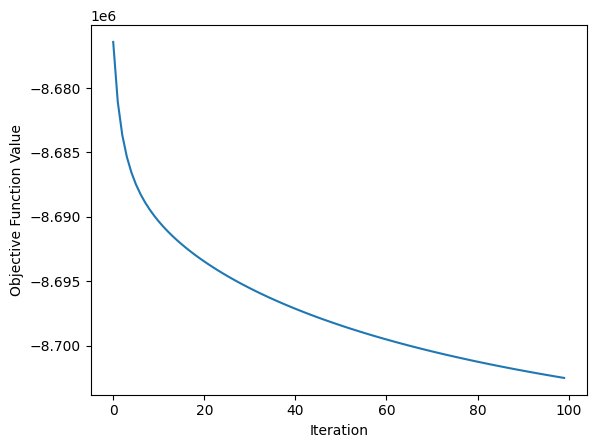

In [ ]:
show2D([new_estimate_noisy, current_estimate, new_estimate_noisy-current_estimate],
       title = ['deconvolved image', 'OSEM image', 'difference'], 
       origin = 'upper', num_cols = 3, fix_range=[(0,150,), (0,150), (-40,40)],
       cmap = [cmap, cmap, 'seismic'])

plt.plot(obj)   
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

# Directional Total Variation 

We use the directional total variation regulariser

$$g(x) =dTV:= \sum_i|D_i\nabla x_i|_2$$

 where the sum is over the pixels $i$ and where $D$ is a weighting vector filed on the gradient in $x$ dependent on the normalised gradient, $\zeta$,  of the reference image, $\nu$ so 
$$D=I-\zeta \zeta^T$$
and $$\zeta = -\dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}}$$ where $0<\eta<<\|\nabla\nu\|$.


We can see that if $\nabla x= \gamma \nabla \nu$ then

 $$D\nabla x = \gamma D\nabla \nu= \gamma (I-\zeta \zeta^T)\nabla \nu= \gamma \left(\nabla \nu -\dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}} \dfrac{\nabla \nu^T }{\sqrt{\eta^2+|\nabla\nu|^2}} \nabla \nu \right)=\gamma\nabla \nu \left(1-(1+\mathcal{O}(\frac{\eta^2}{\|\nabla\nu\|^2}) )\right) \approx 0.$$

We can also see if the gradient of the reconstructed image and the reference image are perpendicular, $\nabla x^T\nabla \nu=0$, then

$$D\nabla x (I-\zeta \zeta^T)\nabla x= \nabla \nu - \dfrac{\nabla \nu }{\sqrt{\eta^2+|\nabla\nu|^2}} \dfrac{\nabla \nu^T }{\sqrt{\eta^2+|\nabla\nu|^2}} \nabla x =\nabla \nu $$

 and is non-zero. 

This regulariser encourages the gradient of the reconstructed image to be equal to parallel to the gradient of the reference image. 

The CCPi regularisation toolkit implementation also allows us to add a non-negativity constraint. 



## Create reference image 

Includes some but not all of the spheres and at different brightness to the ground truth image. 

## Directional TV regularisation, using the regularisation toolkit  


Setting a large alpha leads to a reproduction of the reference image but with the intensity values taken from the measured data: 

In [ ]:
alpha = 0.05

f = KullbackLeibler(b=current_estimate, eta=current_estimate.get_uniform_copy(1e-6))
#f = L2NormSquared(b}=current_estimate)
g = alpha * MixedL21Norm()
F = BlockFunction(f, g)

G = IndicatorBox(0)

grad = GradientOperator(current_estimate)
K = BlockOperator(convolve, grad)

In [ ]:
# Define the step sizes sigma and tau (these are by no means optimal)
normK = K.norm()
sigma = 1./normK
tau = 1./normK

In [ ]:
def update_previous_solution(self):
    tmp = self.x_old
    self.x_old = self.x
    self.x = tmp

PDHG.update_previous_solution = update_previous_solution

In [ ]:
pdhg = PDHG(f = F, g = G, operator = K, tau = 0.99*tau, sigma = 0.99*sigma, initial=current_estimate,
            max_iteration = 1000, update_objective_interval = 50, check_convergence=False)


In [ ]:
pdhg.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.09400e+05
       50       1000         0.680          9.81543e+04
      100       1000         0.675          9.45587e+04
      150       1000         0.676          9.24750e+04
      200       1000         0.676          9.10146e+04
      250       1000         0.675          8.98968e+04
      300       1000         0.674          8.90013e+04
      350       1000         0.674          8.82599e+04
      400       1000         0.673          8.76341e+04
      450       1000         0.672          8.70933e+04
      500       1000         0.669          8.66194e+04
      550       1000         0.661          8.61982e+04
      600       1000         0.654          8.58210e+04
      650       1000         0.648          8.54799e+04
      700       1000         0.643          8.51680e+04
      750       1000         0.639          8.48

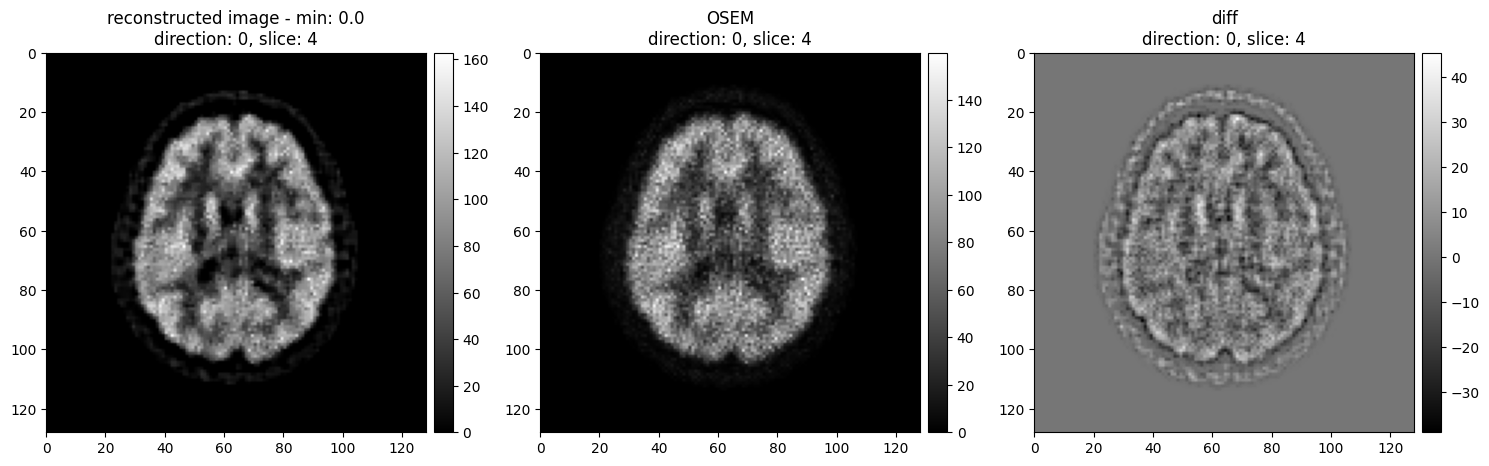

Text(0, 0.5, 'Objective Function Value')

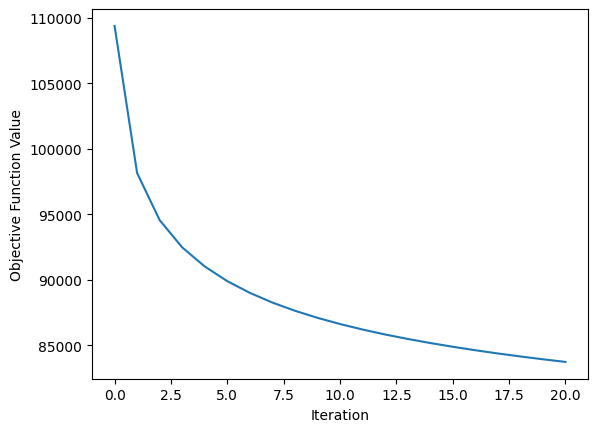

In [ ]:
show2D([pdhg.solution, current_estimate, pdhg.solution-current_estimate], 
       title = [f'reconstructed image - min: {(-pdhg.solution).max()}', 'OSEM', 'diff'], 
       origin = 'upper', num_cols = 3, fix_range=[(0,150,), (0,150), (-40,40)],
       cmap = [cmap, cmap, 'seismic'])

plt.plot(pdhg.objective)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

In [ ]:
# another way

class DirectionalOperator(LinearOperator):

    def __init__(self, anatomical_gradient, gamma = 1, eta=1e-6):

        self.anatomical_gradient = anatomical_gradient
        geometry = BlockGeometry(*[x for x in anatomical_gradient.containers])
        self.tmp = self.anatomical_gradient.containers[0].clone()

        self.gamma = gamma

        self.xi = self.anatomical_gradient/(self.anatomical_gradient.pnorm().power(2)+eta**2).sqrt()

        super(DirectionalOperator, self).__init__(domain_geometry=geometry,
                                       range_geometry=geometry,)
        
    def direct(self, x, out=None):

        if out is None:
            return x - self.gamma * self.xi * self.dot(self.xi, x)
        else:
            out.fill(x - self.gamma * self.xi * self.dot(self.xi, x))
    
    def adjoint(self, x, out=None):
        # This is the same as the direct operator
        return self.direct(x, out)
    
    def dot(self, x, y):
        self.tmp.fill(0)
        for el_x, el_y in zip(x.containers, y.containers):
            self.tmp += el_x * el_y
        return self.tmp
    
        

In [ ]:
grad = GradientOperator(image_dict['PET'])
grad_ref = grad.direct(image_dict['T1'])
d_op = DirectionalOperator(grad_ref)

def calculate_norm(self):
    # return product of operator norms
    return np.prod([op.norm() for op in self.operators])
CompositionOperator.calculate_norm = calculate_norm

operator = CompositionOperator(d_op, grad)

K = BlockOperator(convolve, operator)

In [ ]:
# Define the step sizes sigma and tau (these are by no means optimal)
normK = K.norm()
sigma = 1./normK
tau = 1./normK

In [ ]:
pdhg = PDHG(f = F, g = G, operator = K, tau = 0.99*tau, sigma = 0.99*sigma, initial=current_estimate,
            max_iteration = 1000, update_objective_interval = 50, check_convergence=False)

pdhg.run(verbose=1)

     Iter   Max Iter     Time/Iter            Objective
                               [s]                     
        0       1000         0.000          1.51079e+05
       50       1000         2.471          1.32191e+05
      100       1000         2.587          1.23119e+05
      150       1000         2.230          1.16818e+05
      200       1000         2.041          1.12035e+05
      250       1000         1.922          1.08301e+05
      300       1000         1.843          1.05354e+05
      350       1000         1.799          1.02993e+05
      400       1000         1.757          1.01077e+05
      450       1000         1.727          9.95021e+04
      500       1000         1.700          9.81991e+04
      550       1000         1.676          9.71046e+04
      600       1000         1.649          9.61778e+04
      650       1000         1.627          9.53821e+04
      700       1000         1.604          9.46977e+04
      750       1000         1.585          9.41

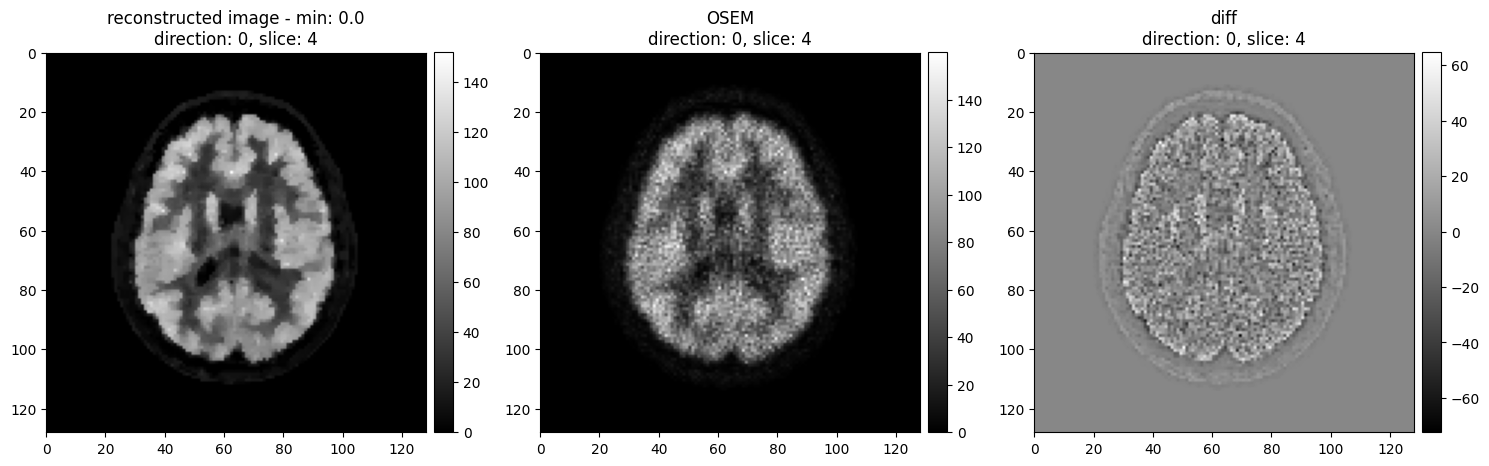

Text(0, 0.5, 'Objective Function Value')

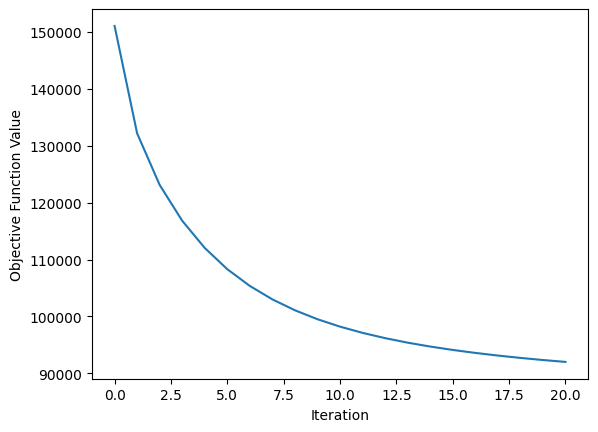

In [ ]:
show2D([pdhg.solution, current_estimate, pdhg.solution-current_estimate], 
       title = [f'reconstructed image - min: {(-pdhg.solution).max()}', 'OSEM', 'diff'], 
       origin = 'upper', num_cols = 3, fix_range=[(0,150,), (0,150), (-40,40)],
       cmap = [cmap, cmap, 'seismic'])

plt.plot(pdhg.objective)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')

In [ ]:
eta = 0.01
alpha = 0.008


# fidelity term
g = L2NormSquared( b=recon_FDK)

# setup operator for directional TV
DY = FiniteDifferenceOperator(ig, direction=1)
DX = FiniteDifferenceOperator(ig, direction=0)

Grad = BlockOperator(DY, DX)
grad_ref = Grad.direct(reference)
denom = (eta**2 + grad_ref.pnorm(2)**2).sqrt()
xi = grad_ref/denom

A1 = DY - CompositionOperator(DiagonalOperator(xi[0]**2),DY) - CompositionOperator(DiagonalOperator(xi[0]*xi[1]),DX)
A2 = DX - CompositionOperator(DiagonalOperator(xi[0]*xi[1]),DY) - CompositionOperator(DiagonalOperator(xi[1]**2),DX)

operator = BlockOperator(A1, A2)

f = alpha * MixedL21Norm()

# use primal acceleration, g being strongly convex
pdhg = PDHG(f = f, g = g, operator = operator, 
            max_iteration=500, update_objective_interval = 100, gamma_g = 1.)
pdhg.run(verbose=0)        


show2D([ground_truth, recon_FDK, algo_tv.solution, reference,  pdhg.solution], title = ['Ground Truth', 'FDK Reconstruction', 'TV solution', 'Reference image',  'dTV solution'], origin = 'upper', num_cols = 2, fix_range=[(0,0.004),(0,0.004),(0,0.004),(0,2),(0,0.004)])
show2D([ground_truth, recon_FDK-ground_truth, algo_tv.solution-ground_truth, reference,  pdhg.solution-ground_truth], title = ['Ground Truth', 'FDK Reconstruction error', 'TV solution error', 'Reference image',  'dTV solution error'], origin = 'upper', cmap=['gray', 'seismic', 'seismic', 'gray', 'seismic'], num_cols = 2, fix_range=[(0, 0.004),(-0.004, 0.004),(-0.004, 0.004),(0,2),(-0.008, 0.008)])


NameError: name 'recon_FDK' is not defined